In this notebook, I test if the SDXL weights I'm using produce sesible results with diffuers. If not, the weights might be broken.

In [1]:
#!pip install -Uqq transformers diffusers 

In [2]:
import torch

In [3]:
from diffusers.models import AutoencoderKL
from diffusers import StableDiffusionXLPipeline

In [4]:
model = "stabilityai/stable-diffusion-xl-base-1.0"
vae = AutoencoderKL.from_pretrained("stabilityai/sdxl-vae", torch_dtype=torch.float16)

In [5]:
pipe = StableDiffusionXLPipeline.from_pretrained(model, vae=vae, torch_dtype=torch.float16)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
pipe = pipe.to('cuda')

In [7]:
prompt  = 'cinematic, shoe in the streets, made from meat, photorealistic shoe, highly detailed'
nprompt = 'lowres, bad anatomy, worst quality, low quality'
size = 8*(756//8)

In [20]:
im = pipe(prompt, width=size, height=size, negative_prompt=nprompt)[0]

  0%|          | 0/50 [00:00<?, ?it/s]

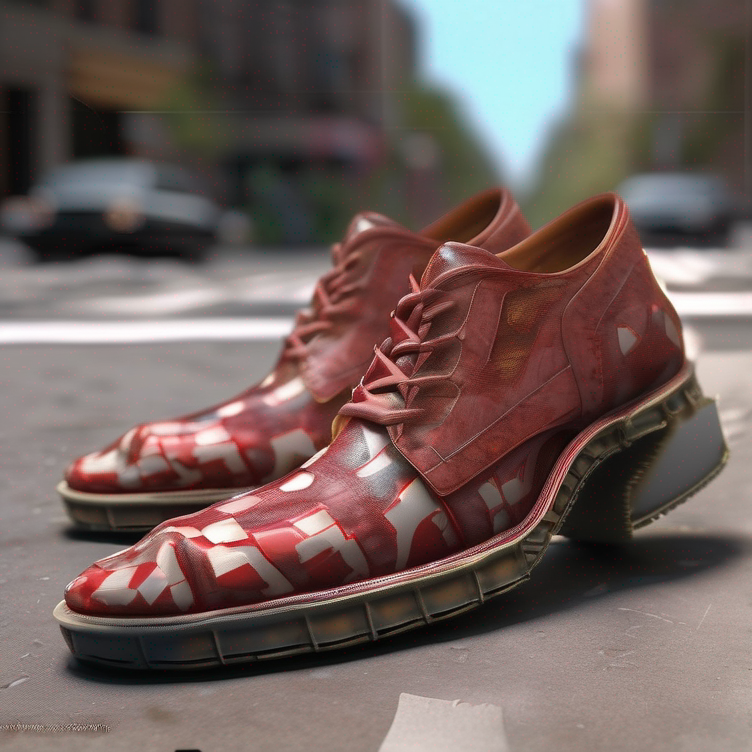

In [21]:
im[0]

In [27]:
im = pipe(prompt, width=size, height=size, negative_prompt=nprompt, num_inference_steps=10)[0]

  0%|          | 0/10 [00:00<?, ?it/s]

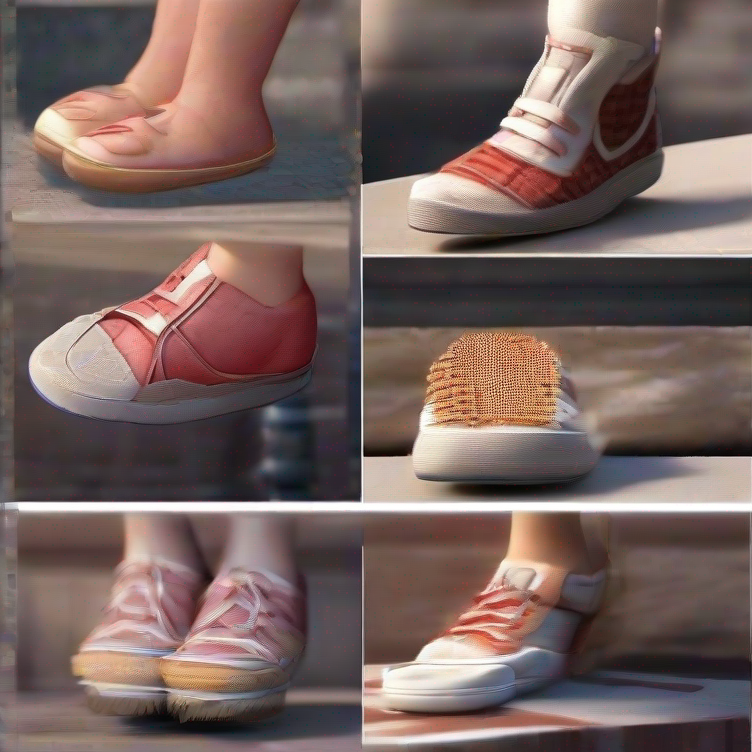

In [28]:
im[0]

___

### Let's save the model and reload it from locally saved weights

In [31]:
pipe.save_pretrained('weights/sdxlvae')

In [2]:
assert False

AssertionError: 

Restart kernel now

___

In [1]:
import torch
from diffusers import StableDiffusionXLPipeline

In [2]:
pipe = StableDiffusionXLPipeline.from_pretrained('weights/sdxlvae').to('cuda')

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
prompt  = 'cinematic, shoe in the streets, made from meat, photorealistic shoe, highly detailed'
nprompt = 'lowres, bad anatomy, worst quality, low quality'
size = 8*(756//8)

  0%|          | 0/50 [00:00<?, ?it/s]

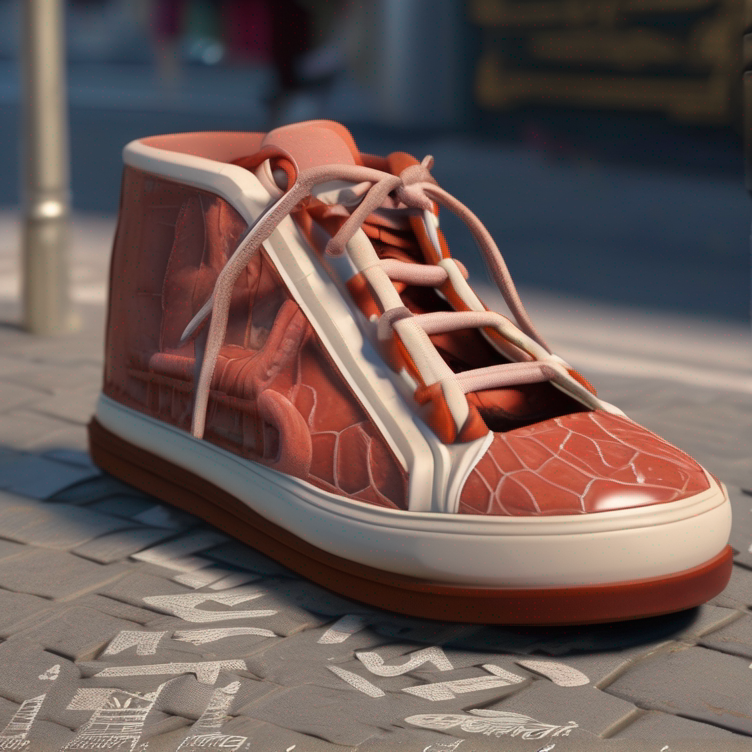

In [5]:
pipe(prompt, width=size, height=size, negative_prompt=nprompt, num_inference_steps=50)[0][0]